# Task 2.  Algorithms for unconstrained nonlinear optimization. Direct methods

### 2.2 Generate random numbers $\alpha \in (0, 1)$  and $\beta \in (0, 1)$. Furthermore, generate the noisy data {$x_k, y_k$}, where $k = 0, 1, .. 100$, according to the rule: $x_k = \frac{k}{100}$, ${y_k = \alpha x_k + \beta + \delta_k}$, where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following linear and rational functions:

### $1) F(x, a, b) = ax + b$ (linear approximant)
### $2) F(x, a, b) = \frac{a}{1 + bx}$ (rational approximant)

### by means of least squares through the numerical minimization (with precision $\varepsilon = 0.001$) of the following function:

### $D(a, b) = \sum_{k = 0}^{100}{(F(x_k, a, b) - y_k)^2}$

### To solve the minimization problem, use the methods of exhaustive search, Gauss and Nelder-Mead. If necessary, set the initial approximations and other parameters of the methods. Visualize the data and the approximants obtained in a plot separately for each type of approximant so that one can compare the results for the numerical methods used. Analyze the results obtained (in terms of number of iterations, precision, number of function evaluations, etc.).

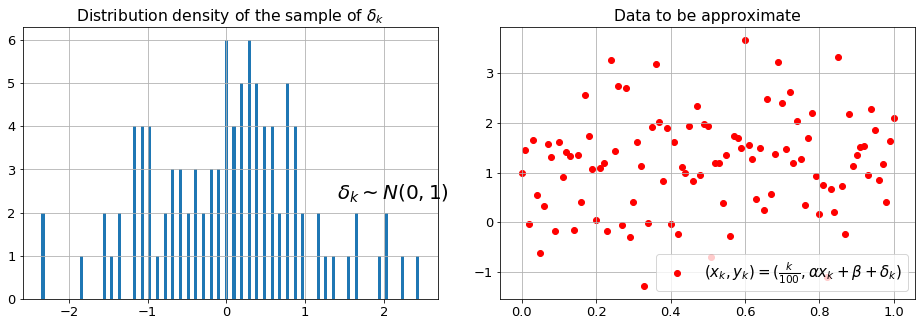

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Visualization + saving generated pairs for Lab_3

mpl.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize = (16, 5))
plt.subplots_adjust(wspace = 0.15)

np.random.seed(4)
el_num = 101
mu, sigma = 0, 1
delta_arr = np.random.normal(mu, sigma, el_num)

plt.subplot(1, 2, 1)
plt.hist(delta_arr, bins = 50, rwidth = 0.4)
plt.text(x = 1.1, y = 2.3, s = r'$\delta_k \sim N(0, 1)$', fontsize = 20)
plt.title('Distribution density of the sample of $\delta_k$')
plt.grid()

x_arr = np.linspace(0, 1, el_num)
alpha, beta = np.random.random(), np.random.random()
y_arr = alpha * x_arr + beta * np.ones(el_num) + delta_arr

plt.subplot(1, 2, 2)
plt.scatter(x_arr, y_arr, c = 'r')
plt.title('Data to be approximate')
plt.legend([r'$(x_k, y_k) = (\frac{k}{100}, \alpha x_k + \beta + \delta_k)$'], loc = 'lower right', fontsize = 15)
plt.grid()
plt.show()

np.save('x_arr', x_arr)
np.save('y_arr', y_arr)

fig.savefig('initial_distribution.png')

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from scipy.optimize import minimize, minimize_scalar


# least_squares_func(*args, **kwargs) == D([a, b], [x_k], [y_k]), where args = [a, b]

def least_squares_linear(args, x_k, y_k):
    return np.sum(np.square(args[0] * x_k + args[1] - y_k))


def least_squares_rational(args, x_k, y_k):
    return np.sum(np.square(args[0] / (1 + args[1] * x_k) - y_k))


def exhaustive_search_mult(func, x_arr, y_arr, left_boundary = -0.9, right_boundary = 1.1, eps = 1e-3):
    
    """ eps = 1e-1 by dafult, because with eps = 1e-3 it takes too much time """
    
    nodes_num = int(1 + (right_boundary - left_boundary) / eps)     # number of nodes in each grid for a and b == len(grid)
    grid = np.linspace(left_boundary, right_boundary, nodes_num)    # grid of values of a and b
    
    func_eval_num = 0
    iter_num = 0
    
    a_min, b_min = grid[0], grid[0]                                 
    func_min = func([a_min, b_min], x_arr, y_arr)    
    func_eval_num += 1
    iter_num += 1
    
    for i in range(nodes_num):                                      # exhaustive search part
        for j in range(nodes_num):
            if (i != 0) and (j != 0):
                
                func_curr = func([grid[i], grid[j]], x_arr, y_arr) 
                func_eval_num += 1
                iter_num += 1

                if func_curr < func_min:
                    a_min, b_min = grid[i], grid[j]
                    func_min = func_curr
    
    n_digits = abs(int(round(np.log10(eps))))
    
    return {'a': round(a_min, n_digits), 'b': round(b_min, n_digits), 'nfev': int(func_eval_num), 'nit': int(iter_num)}


def coordinate_descent_mult(func, x_arr, y_arr, initial_approx = [1, 0], eps = 1e-3):
    
    func_eval_num = 0
    iter_num = 0
    
    a_prev, b_prev = initial_approx[0], initial_approx[1]
    a_curr, b_curr = a_prev + eps, b_prev + eps
        
    while (abs(a_curr - a_prev) >= eps) or (abs(b_curr - b_prev) >= eps):
        
        if iter_num % 2:
            
            res = minimize_scalar(lambda a: func([a, b_prev], x_arr, y_arr))
            
            a_prev, a_curr = a_curr, res.x
            
        else:
            res = minimize_scalar(lambda b: func([a_prev, b], x_arr, y_arr))
            
            b_prev, b_curr = b_curr, res.x

        func_eval_num += res.nfev
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return {'a': round(a_curr, n_digits), 'b': round(b_curr, n_digits), 'nfev': int(func_eval_num), 'nit': int(iter_num)}


def Nelder_Mead_mult(func, x_arr, y_arr, initial_aprox = [1, 0], eps = 1e-3, disp = False):
    
    res = minimize(func, initial_aprox, args = (x_arr, y_arr), method = 'nelder-mead', options = {'xatol': eps, 'disp': disp})
    n_digits = abs(int(round(np.log10(eps))))

    return {'a': round(res.x[0], n_digits), 'b': round(res.x[1], n_digits), 'nfev': int(res.nfev), 'nit': int(res.nit)}


# Testing + saving results for Lab_3

algos_dict = {'exhaustive search': exhaustive_search_mult, 'coordinate descent method': coordinate_descent_mult, \
                   'Nelder Mead method': Nelder_Mead_mult}

algos_names = algos_dict.keys()
sol_dict = {name: {} for name in algos_names}

for alg_name in algos_names:
    sol_dict[alg_name] = {'linear': [], 'rational': []}

for alg_name in algos_names:
    
    sol_dict[alg_name]['linear'] = algos_dict[alg_name](least_squares_linear, x_arr, y_arr, eps = 1e-3)
    sol_dict[alg_name]['rational'] = algos_dict[alg_name](least_squares_rational, x_arr, y_arr, eps = 1e-3)

df = pd.DataFrame(sol_dict)
print(df)  


# Saving results for the next lab:

df_lin = pd.DataFrame([df[col]['linear'] for col in df.columns]).T
df_lin.columns = algos_dict.keys()
df_lin.to_csv('Linear_approx_lab_2.csv')

df_rat = pd.DataFrame([df[col]['rational'] for col in df.columns]).T
df_rat.columns = algos_dict.keys()
df_rat.to_csv('Rational_approx_lab_2.csv')

                                          exhaustive search  \
linear    {'a': 0.451, 'b': 0.965, 'nfev': 4000001, 'nit...   
rational  {'a': 1.012, 'b': -0.285, 'nfev': 4000001, 'ni...   

                                  coordinate descent method  \
linear    {'a': 0.452, 'b': 0.963, 'nfev': 1419, 'nit': ...   
rational  {'a': 1.012, 'b': -0.285, 'nfev': 1505, 'nit':...   

                                         Nelder Mead method  
linear     {'a': 0.451, 'b': 0.965, 'nfev': 109, 'nit': 59}  
rational  {'a': 1.012, 'b': -0.284, 'nfev': 101, 'nit': 56}  


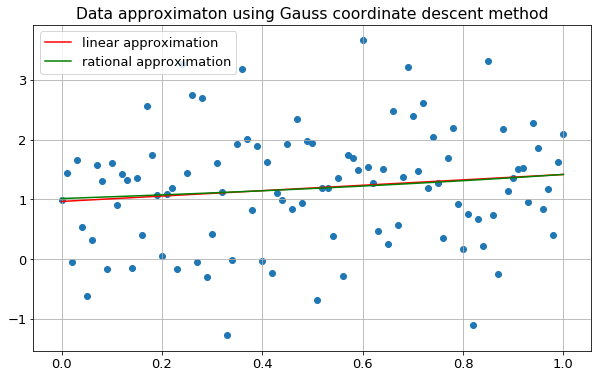

In [5]:
# Vizualization - linar and rational approximation comparison one one plot

fig = plt.figure(figsize = (10, 6))

alg_name = df.columns[1]
plt.title('Data approximaton using Gauss ' + alg_name)
plt.scatter(x_arr, y_arr)

plt.plot(x_arr, df[alg_name]['linear']['a'] * x_arr + df[alg_name]['linear']['b'] , c = 'r')
plt.plot(x_arr, df[alg_name]['rational']['a']  / (1 + x_arr * df[alg_name]['rational']['b'] ), c = 'g')

plt.legend(['linear approximation', 'rational approximation'], loc = 'best')
plt.grid()    
plt.show()

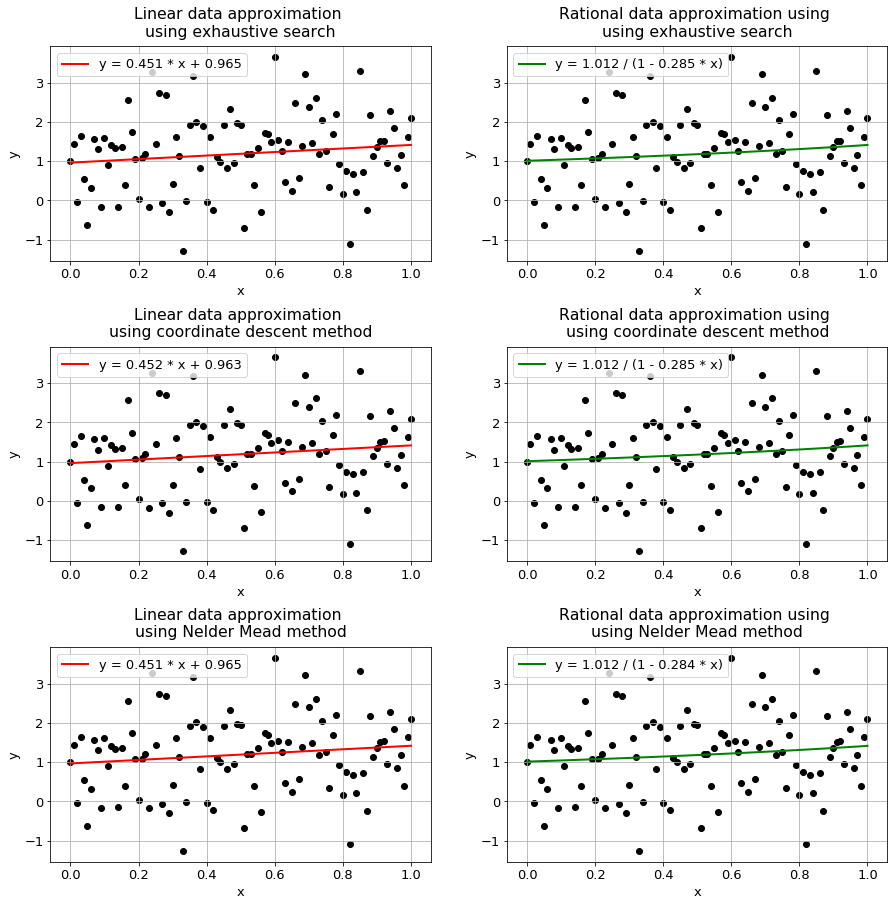

In [6]:
# Vizualization - as it should be

fig = plt.figure(figsize = (15, 15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

for i in range (3):
    
    plt.subplot(3, 2, 2 * i + 1)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, df[df.columns[i]]['linear']['a'] * x_arr + df[df.columns[i]]['linear']['b'], \
             c = 'r', linewidth = 2)

    plt.title('Linear data approximation \n' + 'using ' + df.columns[i], pad = 10)
    plt.legend(['y = {0} * x + {1}'.format(df[df.columns[i]]['linear']['a'], df[df.columns[i]]['linear']['b'])], \
               loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()


    plt.subplot(3, 2, 2 * i + 2)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, df[df.columns[i]]['rational']['a'] / (1 + x_arr * df[df.columns[i]]['rational']['b']), \
             c = 'g', linewidth = 2)

    plt.title('Rational data approximation using \n' + 'using ' + df.columns[i], pad = 10)
    plt.legend(['y = {0} / (1 - {1} * x)'.format(df[df.columns[i]]['rational']['a'], abs(df[df.columns[i]]['rational']['b']))], \
               loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

plt.show()